In [3]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'


In [ ]:

confirmed_cases = cov19.get_jhu_confirmed_cases()



country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

traces = []
models = []
for num_change_points in range(4):
    model = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                        change_points_list = change_points[:num_change_points],
                                        date_begin_simulation = date_begin_sim,
                                        num_days_sim = num_days_sim,
                                        diff_data_sim = diff_data_sim,
                                        N = 83e6,
                                        priors_dict=None)
    models.append(model)

    traces.append(pm.sample(model=model, init='advi', draws=4000))

Cases yesterday (2020-04-07T00:00:00): 107663 and day before yesterday: 103374
pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 357.19:   6%|▋         | 12879/200000 [00:18<04:27, 698.81it/s]
Convergence achieved at 12900
Interrupted at 12,899 [6%]: Average Loss = 476.34
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, lambda_0, I_begin]
Sampling 4 chains, 7 divergences: 100%|██████████| 18000/18000 [03:49<00:00, 78.33draws/s] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 360.03:   6%|▌         | 11796/200000 [00:17<04:38, 675.17it/s]
Convergence achieved at 11800
Interrupted at 11,799 [5%]: Average Loss = 470.56
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_0, transient_begin_0, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 2 divergences:  59%|█████▊    | 10560/18000 [06:10<03:55, 31.59draws/s]

Plots with data from 2020-03-01 to 2020-04-07
[737486. 737496.]


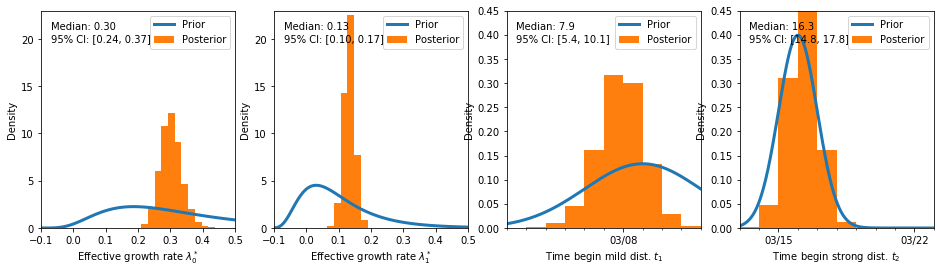

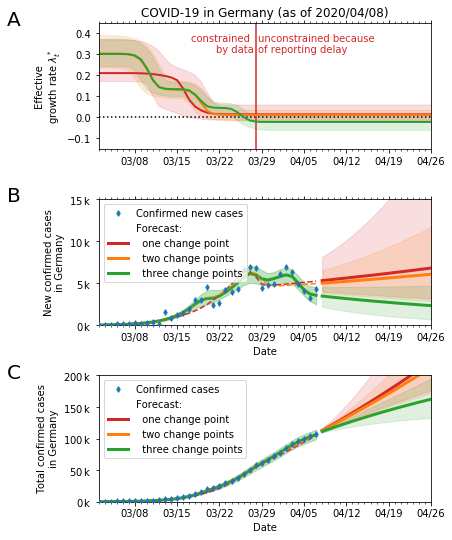

In [14]:
def truncate_number(number, precision):
    return '{{:.{}f}}'.format(precision).format(number)  

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    return 'Median: {}\n95% CI: [{}, {}]'.format(med, perc1, perc2)
def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_begin_sim for date in arr])

print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

trace = traces[3]
posterior = traces[1:]

fig, axes = plt.subplots(1,4, figsize=(16, 4))
#plt.locator_params(nbins=4)
pos_letter = (-0.2, 1)


limit_lambda = (-0.1,0.5)
bins_lambda  = np.linspace(*limit_lambda, 30)


ax = axes[0]
ax.hist(trace.lambda_0 - trace.mu, bins=bins_lambda, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x+1/8, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_ylabel('Density')
ax.set_xlabel('Effective growth rate $\lambda_0^*$')
text = print_median_CI(trace.lambda_0 - trace.mu, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.set_ylim(0,23)


ax = axes[1]
ax.hist(trace.lambda_1 - trace.mu, bins=bins_lambda, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x+1/8, scale=0.2, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_ylabel('Density')
ax.set_xlabel('Effective growth rate $\lambda_1^*$')
text = print_median_CI(trace.lambda_1 - trace.mu, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.set_ylim(0,23)



diff_to_0 = num_days_data + diff_data_sim 


dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

ax = axes[2]
limits = matplotlib.dates.date2num([datetime.date(2020,3,2), datetime.date(2020,3,12)])
bins = np.arange(limits[0], limits[1]+1)
ax.hist(dates_mild, bins=bins, density=True, color='tab:orange',
        label='Posterior')
#limits = ax.get_xlim()
x = np.linspace(*limits, num=1000)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(limits[0], limits[1])
ax.set_ylabel('Density')
ax.set_xlabel('Time begin mild dist. $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_ylim(0,0.45)
print(limits)

ax = axes[3]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)
limits = matplotlib.dates.date2num([datetime.date(2020,3,13), datetime.date(2020,3,23)])
bins = np.arange(limits[0], limits[1]+1)
ax.hist(dates_strong, bins=bins, density=True, color='tab:orange',
        label='Posterior')
#limits = ax.get_xlim()
x = np.linspace(*limits, num=1000)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(limits[0], limits[1])
ax.set_ylabel('Density')
ax.set_xlabel('Time begin strong dist. $t_2$')
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
#ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_ylim(0,0.45)
ax.set_xlim(limits[0], limits[1])



# plt.savefig(path_to_save + 'summary_distributions.png', dpi=300)
# plt.savefig(path_to_save + 'summary_distributions.pdf', dpi=300)


fig, axes = plt.subplots(3,1, figsize=(6.5,7.5), gridspec_kw={'height_ratios': [2, 2,2]})

colors  = ['tab:red', 'tab:orange', 'tab:green']
legends = ['Forecast: ', '  one change point', '  two change points',  '  three change points']

ax = axes[1]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
start_date = mpl_dates[0]
diff_cases =np.diff(cases_obs)
ax.plot(mpl_dates, diff_cases, 'd', label='Confirmed new cases', markersize=4, color='tab:blue', 
            zorder=5)
#ax.plot(mpl_dates, diff_cases, 'd', markersize=4, color='tab:blue', 
#            zorder=6)

new_cases_past = trace.new_cases[:,:num_days_data]
percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color='tab:green', linewidth=3, zorder=-1)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:green')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    end_date = mpl_dates_fut[-10]
    cases_future = trace_scen['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*diff_cases[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
    np.percentile(cases_future, q=2.5, axis=-1),
    np.percentile(cases_future, q=97.5, axis=-1),
    )

    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    #ax.fill_between(mpl_dates, np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
    #            alpha=0.2, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('New confirmed cases\nin Germany')
ax.legend(loc='upper left')
ax.set_ylim(0, 15_000)
# ax.legend(loc='lower left')
#ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.text(-0.275, 0.98, "B", transform=ax.transAxes, size=20)
ax.xaxis.set_ticks_position('both')


ax=axes[2]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
ax.plot(mpl_dates, cases_obs[1:], 'd', label='Confirmed cases', markersize=4, color='tab:blue', 
            zorder=5)
#ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
#            zorder=6)

cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:green', linewidth=3, zorder=-1)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:green')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace_scen['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    #ax.fill_between(mpl_dates, np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
    #                alpha=0.2, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('Total confirmed cases\nin Germany')
ax.legend(loc='upper left')
ax.set_ylim(0, 200_000)
# ax.legend(loc='lower left')
#ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.text(-0.275, 0.98, "C", transform=ax.transAxes, size=20)


ax = axes[0]

time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)

for trace_scen, color in zip(posterior, colors):

    lambda_t = trace_scen['lambda_t'][:, :]
    mu = trace_scen['mu'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(lambda_t-mu, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(lambda_t-mu , q=2.5, axis=0),np.percentile(lambda_t-mu, q=97.5, axis=0), alpha=0.15,
                    color=color)
    #ax.fill_between(mpl_dates, np.percentile(lambda_t , q=12.5, axis=0),np.percentile(lambda_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

ax.set_ylabel('Effective\ngrowth rate $\lambda_t^*$')
# ax.set_xlabel("days from now")
# ax.legend(loc='lower left')
ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.set_ylim(-0.15, 0.45)
#ax.set_yticks([-0.2, 0, 0.2])
#ax.set_aspect(15, adjustable="box")
ax.hlines(0,start_date, end_date, linestyles=':')
delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
#ax.legend()
ax.text(delay+0.4, 0.4, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
ax.text(delay-0.4, 0.4, 'constrained \nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
ax.text(-0.275, 0.98, "A", transform=ax.transAxes, size=20)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_ticks_position('both')

fig.subplots_adjust(hspace=-0.90)
plt.tight_layout()

plt.savefig(path_to_save + 'summary_forecast.pdf', dpi=300)
axes[0].set_title('COVID-19 in Germany (as of {})'.format((date_data_end + datetime.timedelta(days=1)).strftime('%Y/%m/%d')))
plt.savefig(path_to_save + 'summary_forecast.png', dpi=300)

Plots with data from 2020-03-01 to 2020-04-07


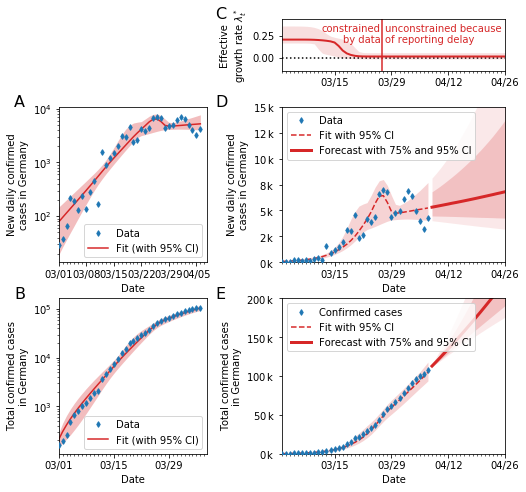

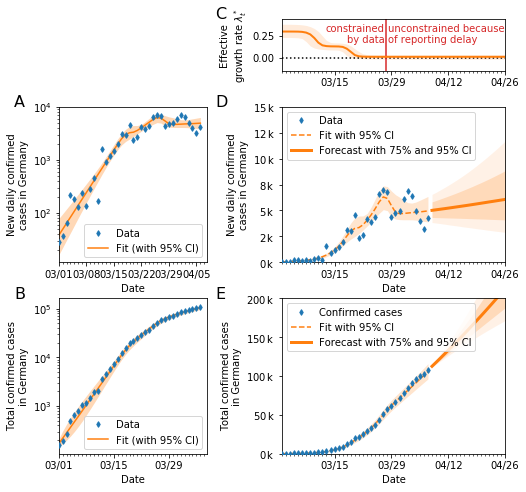

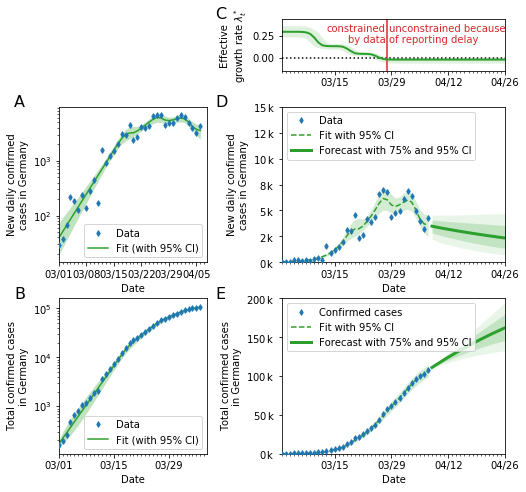

In [4]:


print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

ylabel_new = 'New daily confirmed\ncases in Germany'
ylabel_cum = 'Total confirmed cases\nin Germany'


for trace, color, save_name in zip((traces[1:]),
                                   ('tab:red', 'tab:orange', 'tab:green'),
                                   ('Fig_S1', 'Fig_3', 'Fig_S3')):

    fig, axes = plt.subplots(3,2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 3,3],
                                                                'width_ratios': [2, 3]})
    #plt.locator_params(nbins=4)
    pos_letter = (-0.3, 1)
    titlesize = 16

    ax = axes[1][0]
    time_arr = np.arange(-len(cases_obs)+1, 0)
    mpl_dates = conv_time_to_mpl_dates(time_arr) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=4, label='Data', zorder=5)
    new_cases_past = trace.new_cases[:,:num_days_data]
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color, lw=0)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_new)
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    #plt.savefig(path_to_save + 'check_new_cases.png', dpi=300)

    ax = axes[2][0]
    ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, label='Data', zorder=5)
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color, lw=0)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_cum)
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    ax = axes[1][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', label='Data', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)

    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    #ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', linewidth=3)
    #ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')


    new_cases_past = trace.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color, lw=0)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = trace['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='Forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color, lw=0)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel_new)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 15_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format =lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=titlesize)


    ax = axes[2][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, cases_obs[1:], 'd', label='Confirmed cases', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)


    new_cases_past = trace.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color, lw=0)


    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='Forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color, lw=0)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel_cum)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 200_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format =lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=titlesize)


    ax = axes[0][1]

    time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)
    lambda_t = trace['lambda_t'][:, :]
    mu = trace['mu'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(lambda_t-mu, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(lambda_t-mu , q=2.5, axis=0),np.percentile(lambda_t-mu, q=97.5, axis=0), alpha=0.15,
                    color=color, lw=0)
    #ax.fill_between(mpl_dates, np.percentile(lambda_t , q=12.5, axis=0),np.percentile(lambda_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

    ax.set_ylabel('Effective\ngrowth rate $\lambda_t^*$')
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    # ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    ax.set_ylim(-0.15, 0.45)
    #ax.set_yticks([-0.2, 0, 0.2])
    #ax.set_aspect(15, adjustable="box")
    ax.hlines(0,start_date, end_date, linestyles=':')
    delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
    ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
    #ax.legend()
    ax.text(delay+0.5, 0.4, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
    ax.text(delay-0.5, 0.4, 'constrained\nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
    ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)

    axes[0][0].set_visible(False)

    plt.subplots_adjust(wspace=0.4, hspace=.3)
    plt.savefig(path_to_save + save_name + '.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
    plt.savefig(path_to_save + save_name + '.png', dpi=300, bbox_inches='tight', pad_inches = 0)

No handles with labels found to put in legend.
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:231: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


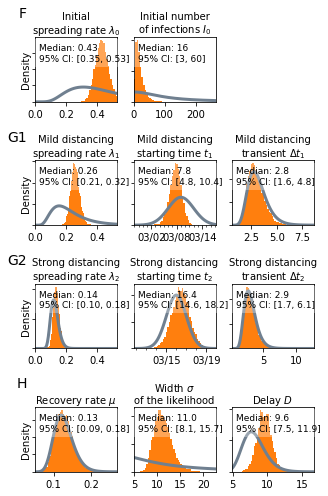

In [5]:
trace=traces[2]
diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:orange']

fig, axes = plt.subplots(4,3, figsize=(5,8))
#plt.locator_params(nbins=4)
pos_letter = (-0.1, 1.3)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9

# LAM 0
limit_lambda = (0,0.53)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment='right')

# INIT INFECTIONS
ax = axes[0][1]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior')
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[1][0]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment='right')

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[1][2]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)

# LAM 2
ax = axes[2][0]
ax.hist(trace.lambda_2, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Strong distancing\nspreading rate $\lambda_2$')
text = print_median_CI(trace.lambda_2, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G2", transform=ax.transAxes, size=size_letters, horizontalalignment='right')

# TIME 2
ax = axes[2][1]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Strong distancing\nstarting time $t_2$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



# Transient T2
ax = axes[2][2]
ax.hist(trace.transient_len_1, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Strong distancing\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_len_1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[3][0]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, horizontalalignment='right')

# WIDTH
ax = axes[3][1]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior')
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[3][2]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

#plt.tight_layout()

ax = axes[0][2]
ax.set_visible(False)
ax.plot([],[], color='#708090', linewidth=3)
ax.hist([0], color='tab:orange')
ax.legend()


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
          ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4) 
        ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
#plt.savefig(path_to_save + 'Fig_4.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
#plt.savefig(path_to_save + 'Fig_4.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:238: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


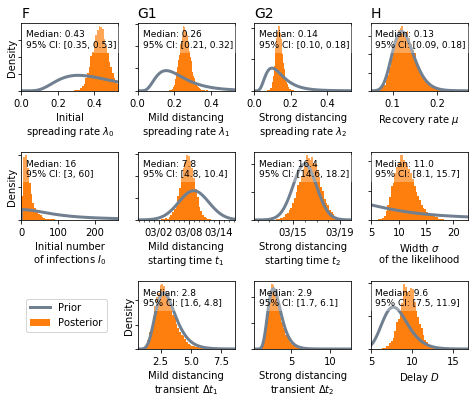

In [6]:
trace=traces[2]
diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:orange']

fig, axes = plt.subplots(3,4, figsize=(8,6))
#plt.locator_params(nbins=4)
pos_letter = (0, 1.08)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9
horizontal_alignment_median = 'left'
horizontal_alignment_letter = 'left'
alpha_hist = 1
zorder_hist = -5

# LAM 0
limit_lambda = (0,0.53)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# INIT INFECTIONS
ax = axes[1][0]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[0][1]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[2][1]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)

# LAM 2
ax = axes[0][2]
ax.hist(trace.lambda_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Strong distancing\nspreading rate $\lambda_2$')
text = print_median_CI(trace.lambda_2, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G2", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 2
ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Strong distancing\nstarting time $t_2$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



# Transient T2
ax = axes[2][2]
ax.hist(trace.transient_len_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Strong distancing\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_len_1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[0][3]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# WIDTH
ax = axes[1][3]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[2][3]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

#plt.tight_layout()

ax = axes[2][0]
ax.set_axis_off()
ax.plot([],[], color='#708090', linewidth=3, label='Prior')
ax.hist([], color='tab:orange', label='Posterior')
ax.legend(loc='center left')


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
            ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4)
        ax.set_rasterization_zorder(-1)
        #ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
plt.savefig(path_to_save + 'Fig_4.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig(path_to_save + 'Fig_4.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


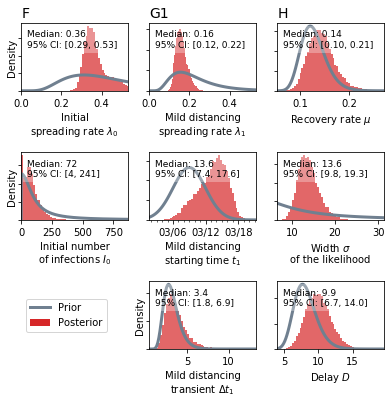

In [7]:
trace=traces[1]
diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:red']

fig, axes = plt.subplots(3,3, figsize=(6.5,6))
#plt.locator_params(nbins=4)
pos_letter = (0, 1.08)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9
horizontal_alignment_median = 'left'
horizontal_alignment_letter = 'left'
alpha_hist = 0.7
zorder_hist = -5

# LAM 0
limit_lambda = (0,0.53)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# INIT INFECTIONS
ax = axes[1][0]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[0][1]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[2][1]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)


# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[0][2]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# WIDTH
ax = axes[1][2]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[2][2]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

#plt.tight_layout()

ax = axes[2][0]
ax.set_axis_off()
ax.plot([],[], color=colors[0], linewidth=3, label='Prior')
ax.hist([], color=colors[1], label='Posterior')
ax.legend(loc='center left')


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
            ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4)
        ax.set_rasterization_zorder(-1)
        #ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
plt.savefig(path_to_save + 'Fig_S2.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig(path_to_save + 'Fig_S2.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:295: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


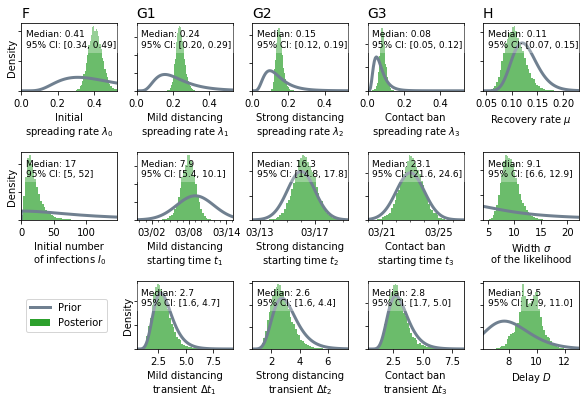

In [15]:
trace=traces[3]
diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:green']

fig, axes = plt.subplots(3,5, figsize=(10,6))
#plt.locator_params(nbins=4)
pos_letter = (0, 1.08)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9
horizontal_alignment_median = 'left'
horizontal_alignment_letter = 'left'
alpha_hist = 0.7
zorder_hist = -5

# LAM 0
limit_lambda = (0,0.53)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# INIT INFECTIONS
ax = axes[1][0]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[0][1]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[2][1]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)

# LAM 2
ax = axes[0][2]
ax.hist(trace.lambda_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Strong distancing\nspreading rate $\lambda_2$')
text = print_median_CI(trace.lambda_2, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G2", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 2
ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Strong distancing\nstarting time $t_2$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



# Transient T2
ax = axes[2][2]
ax.hist(trace.transient_len_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Strong distancing\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_len_1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# LAM 3
ax = axes[0][3]
ax.hist(trace.lambda_3, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8/2, s=0.5), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Contact ban\nspreading rate $\lambda_3$')
text = print_median_CI(trace.lambda_3, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G3", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 3
ax = axes[1][3]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_2)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_contact_ban_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Contact ban\nstarting time $t_3$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))


# Transient T3
ax = axes[2][3]
ax.hist(trace.transient_len_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Contact ban\ntransient $\Delta t_3$')
text = print_median_CI(trace.transient_len_2, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[0][4]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# WIDTH
ax = axes[1][4]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[2][4]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

#plt.tight_layout()

ax = axes[2][0]
ax.set_axis_off()
ax.plot([],[], color=colors[0], linewidth=3, label='Prior')
ax.hist([], color=colors[1], label='Posterior')
ax.legend(loc='center left')


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
            ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4)
        ax.set_rasterization_zorder(-1)
        #ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
plt.savefig(path_to_save + 'Fig_S4.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig(path_to_save + 'Fig_S4.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
print('\n0 step model\n')
print(pm.loo(traces[0], model))

print('\n1 step model\n')
print(pm.loo(traces[1], model))

print('\n2 steps model\n')
print(pm.loo(traces[2], model))

print('\n3 steps model\n')
print(pm.loo(traces[3], model))


0 step model

Computed from 16000 by 37 log-likelihood matrix

       Estimate       SE
IC_loo   642.04    13.79
p_loo      3.86        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       37  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


1 step model

